# Purpose:
- Transform the master map back to each session
    - using twostep_reverse for suite2p nonrigid registration, 
    - inverse matrix for affine registration, and
    - round-trip registration for bilinear registration.
- Visually check if the back registration worked as intented.
- Quantify ROI overlap to session ROIs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import napari
import os, shutil
import tqdm

from suite2p.registration import rigid, nonrigid
from suite2p import extraction
from suite2p.extraction import create_masks_and_extract
from suite2p.detection import roi_stats

from pystackreg import StackReg

def data_3d_array(data):
    if isinstance(data,list):
        data = np.array(data)
    if len(data.shape)==2:
        data = np.expand_dims(data,axis=0)
    return data

def affine_reverse(roi_map, tmat):
    '''
    Reverse StackReg affine registration.
    Parameters
    ----------
        roi_map: 3D roi maps, or a list of 2D roi maps
        tmat: StackReg tmat
    Returns
    -------
        reverse_roi_map (np.ndarray): 3D roi maps
    '''
    roi_map = data_3d_array(roi_map)
    reverse_tmat = np.linalg.inv(tmat)
    sr = StackReg(StackReg.AFFINE)
    reverse_roi_map = []
    for i in range(roi_map.shape[0]):
        reverse_map = sr.transform(roi_map[i,:,:], tmat=reverse_tmat)
        reverse_map = reverse_map > 0.5
        reverse_roi_map.append(reverse_map)
    return np.array(reverse_roi_map)

def affine_reverse_session(session_roi_map, tforms):
    '''
    Reverse StackReg affine registration for roi maps, for each session.
    Apply inverse transformation of the tmat.
    Parameters
    ----------
        session_roi_map: 2D or 3D roi maps
        tforms: list of StackReg tmat
    Returns
    -------
        np.array(reverse_map_list): array of reverse-registered ROI maps.
    '''
    session_roi_map = data_3d_array(session_roi_map)
    assert session_roi_map.shape[0] == len(tforms)
    sr = StackReg(StackReg.AFFINE)
    reverse_map_list = []
    for i in range(len(tforms)):
        tmat = tforms[i]
        reverse_tmat = np.linalg.inv(tmat)
        reverse_map = sr.transform(session_roi_map[i,:,:], tmat=reverse_tmat)
        reverse_map = reverse_map > 0.5
        reverse_map_list.append(reverse_map)
    return np.array(reverse_map_list)

def bilinear_reverse(roi_map, img, reg_FOV):
    '''
    Reverse StackReg bilinear registration.
    Parameters
    ----------
        roi_map: 3D roi maps, or a list of 2D roi maps
        img: 2D image of the original FOV
        reg_FOV: 2D image of the registered FOV
    Returns
    -------
        reverse_roi_map (np.ndarray): 3D roi maps
    '''
    sr = StackReg(StackReg.BILINEAR)
    roi_map = data_3d_array(roi_map)
    reverse_tmat = sr.register(img, reg_FOV)
    reverse_roi_map = []
    for i in range(roi_map.shape[0]):
        reverse_map = sr.transform(roi_map[i,:,:], tmat=reverse_tmat)
        reverse_map = reverse_map > 0.5
        reverse_roi_map.append(reverse_map)
    return np.array(reverse_roi_map)


def bilinear_reverse_session(session_roi_map, img, reg_FOV):
    '''
    Reverse StackReg bilinear registration for each session.
    Apply round-trip registration, i.e., use tmat from the registered FOV to the original FOV
        to transform the ROI map
    Parameters
    ----------
        session_roi_map: 2D or 3D roi maps. In case of 3D, axis=0 is for each session
        img: 2d or 3d images. or list of 2d images (original FOVs that used to calculate tforms)
        reg_FOV: 2d or 3d images. or list of 2d images (registered FOVs)
    Returns
    -------
        np.array(reverse_map_list): array of reverse-registered ROI maps.
    '''
    sr = StackReg(StackReg.BILINEAR)
    session_roi_map = data_3d_array(session_roi_map)
    img = data_3d_array(img)
    reg_FOV = data_3d_array(reg_FOV)

    assert session_roi_map.shape == img.shape    
    assert img.shape == reg_FOV.shape

    reverse_map_list = []
    nimg = img.shape[0]
    for i in range(nimg):
        reverse_tmat = sr.register(img[i,:,:], reg_FOV[i,:,:])
        reverse_map = sr.transform(session_roi_map[i,:,:], tmat=reverse_tmat)
        reverse_map = reverse_map > 0.5
        reverse_map_list.append(reverse_map)
    return np.array(reverse_map_list)

def twostep_register_reverse(img, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                     rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2):
    '''
    Reverse twostep_register
    All the inputs are the same as those used for the original twostep_register
    '''
    from itertools import repeat
    
    img = data_3d_array(img)
    frames = img.copy().astype(np.float32)
    (Ly, Lx) = frames.shape[1:]
    
    num_img = frames.shape[0]

    if len(rigid_y1.shape) == 0:
        if num_img > 1:
            rigid_y1 = np.array(list(repeat(rigid_y1, num_img)))
            rigid_x1 = np.array(list(repeat(rigid_x1, num_img)))
            rigid_y2 = np.array(list(repeat(rigid_y2, num_img)))
            rigid_x2 = np.array(list(repeat(rigid_x2, num_img)))
    
    # 1st nonrigid shift (reversing 2nd nonrigid)
    yblock, xblock, nblocks, block_size, NRsm = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=block_size2)
    ymax1 = np.tile(-nonrigid_y2, (frames.shape[0],1))
    xmax1 = np.tile(-nonrigid_x2, (frames.shape[0],1))
    frames = nonrigid.transform_data(data=frames, nblocks=nblocks, 
        xblock=xblock, yblock=yblock, ymax1=ymax1, xmax1=xmax1)
    
    # 1st rigid shift (reversing 2nd rigid)
    for frame, dy, dx in zip(frames, -rigid_y2, -rigid_x2):
        frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
    
    # 2nd nonrigid shift (reversing 1st nonrigid)
    yblock, xblock, nblocks, block_size, NRsm = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=block_size1)
    ymax1 = np.tile(-nonrigid_y1, (frames.shape[0],1))
    xmax1 = np.tile(-nonrigid_x1, (frames.shape[0],1))
    frames = nonrigid.transform_data(data=frames, nblocks=nblocks, 
        xblock=xblock, yblock=yblock, ymax1=ymax1, xmax1=xmax1)
    
    # 2nd rigid shift (reversing 1st rigid)
    for frame, dy, dx in zip(frames, -rigid_y1, -rigid_x1):
        frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
    
    return frames
    
def fix_reg_collection(reg_result):
    '''
    Fixing registration result collection of the 'new' suite2p method.
    2022/07/13 JK
    '''
    num_sessions = len(reg_result['selected_session_num'])
    roff1_y = [0]
    roff1_x = [0]
    roff1_c = [0.1]
    roff1 = reg_result['suite2p_result']['roff1']
    for i in range(num_sessions-1):
        roff1_y.append([x[0] for x in roff1[i]][0])
        roff1_x.append([x[0] for x in roff1[i]][1])
        roff1_c.append([x[0] for x in roff1[i]][2])
    roff1 = [[np.array(roff1_y), np.array(roff1_x), np.array(roff1_c)]]
    reg_result['suite2p_result']['roff1'] = roff1

    roff2_y = [0]
    roff2_x = [0]
    roff2_c = [0.1]
    roff2 = reg_result['suite2p_result']['roff2']
    for i in range(num_sessions-1):
        roff2_y.append([x[0] for x in roff2[i]][0])
        roff2_x.append([x[0] for x in roff2[i]][1])
        roff2_c.append([x[0] for x in roff2[i]][2])
    roff2 = [[np.array(roff2_y), np.array(roff2_x), np.array(roff2_c)]]
    reg_result['suite2p_result']['roff2'] = roff2

    offset_len = len(reg_result['suite2p_result']['nroff1'][0][0][0])
    nroff1_y = [np.zeros(offset_len)]
    nroff1_x = [np.zeros(offset_len)]
    nroff1_c = [np.ones(offset_len)/10]
    nroff1 = reg_result['suite2p_result']['nroff1']
    for i in range(num_sessions-1):
        nroff1_y.append([x[0] for x in nroff1[i]][0])
        nroff1_x.append([x[0] for x in nroff1[i]][1])
        nroff1_c.append([x[0] for x in nroff1[i]][2])
    nroff1 = [[np.array(nroff1_y).astype(np.float32), np.array(nroff1_x).astype(np.float32), np.array(nroff1_c).astype(np.float32)]]
    reg_result['suite2p_result']['nroff1'] = nroff1
    
    offset_len = len(reg_result['suite2p_result']['nroff2'][0][0][0])
    nroff2_y = [np.zeros(offset_len)]
    nroff2_x = [np.zeros(offset_len)]
    nroff2_c = [np.ones(offset_len)/10]
    nroff2 = reg_result['suite2p_result']['nroff2']
    for i in range(num_sessions-1):
        nroff2_y.append([x[0] for x in nroff2[i]][0])
        nroff2_x.append([x[0] for x in nroff2[i]][1])
        nroff2_c.append([x[0] for x in nroff2[i]][2])
    nroff2 = [[np.array(nroff2_y).astype(np.float32), np.array(nroff2_x).astype(np.float32), np.array(nroff2_c).astype(np.float32)]]
    reg_result['suite2p_result']['nroff2'] = nroff2

    return reg_result

def gather_session_roi_map(planeDir, selected_session_num, edge_buffer, viable_cell_index_list):
    '''
    Gather ROI map from each session, truncate to the same dimension as processed data
    '''
    topBuffer = edge_buffer['topBuffer']
    bottomBuffer = edge_buffer['bottomBuffer']
    leftBuffer = edge_buffer['leftBuffer']
    rightBuffer = edge_buffer['rightBuffer']
    session_og_map_list = []
    for i, snum in enumerate(selected_session_num):
        tempStat = np.load(f'{planeDir}{snum:03}/plane0/stat.npy', allow_pickle=True)
        tempIscell = np.load(f'{planeDir}{snum:03}/plane0/iscell.npy', allow_pickle=True)
        ops = np.load(f'{planeDir}{snum:03}/plane0/ops.npy', allow_pickle=True).item()
        Ly, Lx = ops['Ly'], ops['Lx']

        if 'inmerge' in tempStat[0].keys():
            merged_ind = np.where([ts['inmerge']>0 for ts in tempStat])[0]
            if len(merged_ind) > 0:
                tempIscell[merged_ind,0] = 0
        
        viable_cell_index = viable_cell_index_list[i]
        numCell = len(viable_cell_index)
        tempMap = np.zeros((numCell,Ly,Lx), 'bool')
        for n, ci in enumerate(viable_cell_index):
            xi = tempStat[ci]['xpix']
            yi = tempStat[ci]['ypix']
            tempMap[n,yi,xi] = 1

        # Remove ROIs overlapping with the registration buffer (for bidirectional noise and optotune ringing noise)        
        tempMap = tempMap[:,topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]
        session_og_map_list.append(tempMap)
    return session_og_map_list

h5Dir = 'H:/'
# mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
# freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    6.1,    6.1,    6.1,    7.7,    7.7,    7.7,    7.7]

mice =          [25,    27,   30,   36,     39,     52]
refSessions =   [4,     3,    3,    1,      1,      3]
expSessions =   [19,    10,   21,   17,     23,     21]
zoom =          [2,     2,    2,    1.7,    1.7,    1.7]
freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    7.7]

In [28]:
# Check if reverse registration works as intended
mi = 0
mouse = mice[mi]
pn = 1

planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
edge_buffer = session_to_session_registration['edge_buffer']
reg_meth = session_to_session_registration['registration_method']

print(reg_meth)

roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection.npy', allow_pickle=True).item()
# master_map = roi_collection['master_map_list'][-1]
session_map_list = [np.sum(sm, axis=0) for sm in roi_collection['session_map_list']]
viable_cell_index_list = roi_collection['viable_cell_index_list']
session_og_map_list = [np.sum(sm, axis=0) for sm in gather_session_roi_map(planeDir, selected_session_num, edge_buffer, viable_cell_index_list)]

if reg_meth=='affine':
    tforms = session_to_session_registration['affine_result']['tformsAffine']
    session_reverse_map = affine_reverse_session(session_map_list,tforms)
elif reg_meth == 'bilinear':
    img_list = []
    for sn in selected_session_num:
        opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
        ops = np.load(opsFn, allow_pickle=True).item()
        topBuffer = edge_buffer['topBuffer']
        bottomBuffer = edge_buffer['bottomBuffer']
        leftBuffer = edge_buffer['leftBuffer']
        rightBuffer = edge_buffer['rightBuffer']
        mimg = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
        img_list.append(mimg)
    reg_FOV = session_to_session_registration['bilinear_result']['reg_image']
    session_reverse_map = bilinear_reverse_session(session_map_list, img_list, reg_FOV)
elif reg_meth == 'suite2p':
    session_to_session_registration = fix_reg_collection(session_to_session_registration)
    reg_result = session_to_session_registration['suite2p_result']
else:
    reg_result = session_to_session_registration['old_result']

if (reg_meth == 'old') or (reg_meth == 'suite2p'):

    # rigid_y1 = reg_result['roff1'][0][0][si]
    # rigid_x1 = reg_result['roff1'][0][1][si]
    # nonrigid_y1 = reg_result['nroff1'][0][0][si,:]
    # nonrigid_x1 = reg_result['nroff1'][0][1][si,:]
    
    # rigid_y2 = reg_result['roff2'][0][0][si]
    # rigid_x2 = reg_result['roff2'][0][1][si]
    # nonrigid_y2 = reg_result['nroff2'][0][0][si,:]
    # nonrigid_x2 = reg_result['nroff2'][0][1][si,:]

    rigid_y1 = reg_result['roff1'][0][0]
    rigid_x1 = reg_result['roff1'][0][1]
    nonrigid_y1 = reg_result['nroff1'][0][0]
    nonrigid_x1 = reg_result['nroff1'][0][1]
    
    rigid_y2 = reg_result['roff2'][0][0]
    rigid_x2 = reg_result['roff2'][0][1]
    nonrigid_y2 = reg_result['nroff2'][0][0]
    nonrigid_x2 = reg_result['nroff2'][0][1]

    block_size1 = reg_result['block_size1']
    block_size2 = reg_result['block_size2']

    session_reverse_map = twostep_register_reverse(session_map_list, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                     rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)

viewer = napari.Viewer()
viewer.add_image(np.array(session_og_map_list), name='original map')
viewer.add_image(np.array(session_reverse_map), name='reverse map')

bilinear


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'reverse map' at 0x1fe03553af0>

In [8]:
# Check if reverse registration using the master map matches with the session map
mi = 2
mouse = mice[mi]
pn = 3

planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
edge_buffer = session_to_session_registration['edge_buffer']
reg_meth = session_to_session_registration['registration_method']

print(reg_meth)

roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection.npy', allow_pickle=True).item()
master_map = np.sum(roi_collection['master_map_list'][-1],axis=0)
# session_map_list = [np.sum(sm, axis=0) for sm in roi_collection['session_map_list']]
viable_cell_index_list = roi_collection['viable_cell_index_list']
session_og_map_list = [np.sum(sm, axis=0) for sm in gather_session_roi_map(planeDir, selected_session_num, edge_buffer, viable_cell_index_list)]

if reg_meth=='affine':
    tforms = session_to_session_registration['affine_result']['tformsAffine']
    master_reverse_map = affine_reverse_session(np.tile(master_map, (len(session_og_map_list),1,1)),tforms)
elif reg_meth == 'bilinear':
    img_list = []
    for sn in selected_session_num:
        opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
        ops = np.load(opsFn, allow_pickle=True).item()
        topBuffer = edge_buffer['topBuffer']
        bottomBuffer = edge_buffer['bottomBuffer']
        leftBuffer = edge_buffer['leftBuffer']
        rightBuffer = edge_buffer['rightBuffer']
        mimg = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
        img_list.append(mimg)
    reg_FOV = session_to_session_registration['bilinear_result']['reg_image']
    master_reverse_map = bilinear_reverse_session(np.tile(master_map, (len(img_list),1,1)), img_list, reg_FOV)
elif reg_meth == 'suite2p':
    session_to_session_registration = fix_reg_collection(session_to_session_registration)
    reg_result = session_to_session_registration['suite2p_result']
else:
    reg_result = session_to_session_registration['old_result']

if (reg_meth == 'old') or (reg_meth == 'suite2p'):
    rigid_y1 = reg_result['roff1'][0][0]
    rigid_x1 = reg_result['roff1'][0][1]
    nonrigid_y1 = reg_result['nroff1'][0][0]
    nonrigid_x1 = reg_result['nroff1'][0][1]
    
    rigid_y2 = reg_result['roff2'][0][0]
    rigid_x2 = reg_result['roff2'][0][1]
    nonrigid_y2 = reg_result['nroff2'][0][0]
    nonrigid_x2 = reg_result['nroff2'][0][1]

    block_size1 = reg_result['block_size1']
    block_size2 = reg_result['block_size2']

    master_reverse_map = twostep_register_reverse(np.tile(master_map, (len(session_og_map_list),1,1)), rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                     rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)

viewer = napari.Viewer()
viewer.add_image(np.array(session_og_map_list), name='original map')
viewer.add_image(np.array(master_reverse_map), name='reverse master map')

old


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'reverse master map' at 0x16f1f9a7190>

In [7]:
len(master_reverse_map)

8

# Visual inspection result
All 3 mice (025,027,030) showed close to perfect match when registered back to each session.

# Now, register master map back to each session
- Create stat_master.npy
    - lambda=1 (or 1 / num_pixel)
- Create iscell_master.npy
- These two are same for all sessions. So just one file on the plane folder.
<br><br>
- Then, extract signals.

In [2]:
# Deal with cases where reverse mapping results in ROI loss (partial or whole)
# So, first I need to run all the reverse mapping and then filter out ROIs lost.
# Save this as the final master map.
# Save each reverse mapping as well, with revised viable cell index list.

mi = 0
mouse = mice[mi]
pn = 2

planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection.npy', allow_pickle=True).item()
master_map = roi_collection['master_map_list'][-1]

session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
reg_meth = session_to_session_registration['registration_method']
if reg_meth == 'suite2p':
    session_to_session_registration = fix_reg_collection(session_to_session_registration)

selected_session_num = session_to_session_registration['selected_session_num']
edge_buffer = session_to_session_registration['edge_buffer']
topBuffer = edge_buffer['topBuffer']
bottomBuffer = edge_buffer['bottomBuffer']
leftBuffer = edge_buffer['leftBuffer']
rightBuffer = edge_buffer['rightBuffer']

master_map_sessions = []
for si in range(len(selected_session_num)):
    print(f'Processing {si}/{len(selected_session_num)-1}')
    sn = selected_session_num[si]

    opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
    ops = np.load(opsFn, allow_pickle=True).item()
    ops['reg_file'] = f'{planeDir}{sn:03}/plane0/data.bin'

    if reg_meth == 'affine':
        tmat = session_to_session_registration['affine_result']['tformsAffine'][si]
        temp_master_reverse = affine_reverse(master_map, tmat)
    elif reg_meth == 'bilinear':
        mimg = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
        reg_FOV = session_to_session_registration['bilinear_result']['reg_image'][si]
        temp_master_reverse = bilinear_reverse(master_map, mimg, reg_FOV)
    else: # suite2p or old
        if reg_meth == 'suite2p':
            reg_result = session_to_session_registration['suite2p_result']
        else: #'old'
            reg_result = session_to_session_registration['old_result']
        rigid_y1 = reg_result['roff1'][0][0][si]
        rigid_x1 = reg_result['roff1'][0][1][si]
        nonrigid_y1 = reg_result['nroff1'][0][0][si,:]
        nonrigid_x1 = reg_result['nroff1'][0][1][si,:]
        
        rigid_y2 = reg_result['roff2'][0][0][si]
        rigid_x2 = reg_result['roff2'][0][1][si]
        nonrigid_y2 = reg_result['nroff2'][0][0][si,:]
        nonrigid_x2 = reg_result['nroff2'][0][1][si,:]
        
        block_size1 = reg_result['block_size1']
        block_size2 = reg_result['block_size2']

        temp_master_reverse_float = twostep_register_reverse(master_map, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                        rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)
        temp_master_reverse = np.zeros(temp_master_reverse_float.shape, dtype='bool')
        for i in range(temp_master_reverse_float.shape[0]):
            temp_master_reverse[i,:,:] = temp_master_reverse_float[i,:,:]>0.5
    master_map_sessions.append(temp_master_reverse)
    
vanishing_roi_ind_list = []
for i in range(len(master_map_sessions)):
    vanishing_roi_ind = np.where([np.sum(mm)==0 for mm in master_map_sessions[i]])[0]
    if len(vanishing_roi_ind)>0:
        for j in range(len(vanishing_roi_ind)):
            vanishing_roi_ind_list.append(vanishing_roi_ind[j])

fov_edge = np.zeros(master_map[0].shape, dtype='bool')
fov_edge[0,:] = 1
fov_edge[-1,:] = 1
fov_edge[:,0] = 1
fov_edge[:,-1] = 1

edge_roi_ind_list = []
for i in range(len(master_map_sessions)):
    edge_roi_ind = np.where([np.sum(mm*fov_edge)>0 for mm in master_map_sessions[i]])[0]
    if len(edge_roi_ind)>0:
        for j in range(len(edge_roi_ind)):
            edge_roi_ind_list.append(edge_roi_ind[j])

ind_to_remove = vanishing_roi_ind_list + edge_roi_ind_list
ind_to_remove = np.unique(ind_to_remove)
remaining_ind = np.setdiff1d(range(master_map_sessions[0].shape[0]), ind_to_remove)

viewer = napari.Viewer()
viewer.add_image(np.array([np.sum(mm,axis=0) for mm in master_map_sessions]))
viewer.add_image(np.array([np.sum(mm[remaining_ind,:,:],axis=0) for mm in master_map_sessions]))

Processing 0/14
Processing 1/14
Processing 2/14
Processing 3/14
Processing 4/14
Processing 5/14
Processing 6/14
Processing 7/14
Processing 8/14
Processing 9/14
Processing 10/14
Processing 11/14
Processing 12/14
Processing 13/14
Processing 14/14


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Image [1]' at 0x152e162a6a0>

In [114]:
# Run through mice and planes and save the final master map and session-speicific final viable cell indices and matched master roi index
for mi in tqdm.notebook.tqdm(range(3)):
    mouse = mice[mi]
    for pn in tqdm.notebook.tqdm(range(1,9)):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        final_roi_collection_fn = f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_final.npy'
        
        # if os.path.isfile(final_roi_collection_fn) != True:
        if True:
            roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection.npy', allow_pickle=True).item()
            master_map = roi_collection['master_map_list'][-1]

            session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
            reg_meth = session_to_session_registration['registration_method']
            if reg_meth == 'suite2p':
                session_to_session_registration = fix_reg_collection(session_to_session_registration)

            selected_session_num = session_to_session_registration['selected_session_num']
            edge_buffer = session_to_session_registration['edge_buffer']
            topBuffer = edge_buffer['topBuffer']
            bottomBuffer = edge_buffer['bottomBuffer']
            leftBuffer = edge_buffer['leftBuffer']
            rightBuffer = edge_buffer['rightBuffer']

            # Reverse registration of the master map back to each session
            master_map_sessions = []
            for si in range(len(selected_session_num)):
                sn = selected_session_num[si]

                opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
                ops = np.load(opsFn, allow_pickle=True).item()
                ops['reg_file'] = f'{planeDir}{sn:03}/plane0/data.bin'

                if reg_meth == 'affine':
                    tmat = session_to_session_registration['affine_result']['tformsAffine'][si]
                    temp_master_reverse = affine_reverse(master_map, tmat)
                elif reg_meth == 'bilinear':
                    mimg = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
                    reg_FOV = session_to_session_registration['bilinear_result']['reg_image'][si]
                    temp_master_reverse = bilinear_reverse(master_map, mimg, reg_FOV)
                else: # suite2p or old
                    if reg_meth == 'suite2p':
                        reg_result = session_to_session_registration['suite2p_result']
                    else: #'old'
                        reg_result = session_to_session_registration['old_result']
                    rigid_y1 = reg_result['roff1'][0][0][si]
                    rigid_x1 = reg_result['roff1'][0][1][si]
                    nonrigid_y1 = reg_result['nroff1'][0][0][si,:]
                    nonrigid_x1 = reg_result['nroff1'][0][1][si,:]
                    
                    rigid_y2 = reg_result['roff2'][0][0][si]
                    rigid_x2 = reg_result['roff2'][0][1][si]
                    nonrigid_y2 = reg_result['nroff2'][0][0][si,:]
                    nonrigid_x2 = reg_result['nroff2'][0][1][si,:]
                    
                    block_size1 = reg_result['block_size1']
                    block_size2 = reg_result['block_size2']

                    temp_master_reverse_float = twostep_register_reverse(master_map, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                                    rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)
                    temp_master_reverse = np.zeros(temp_master_reverse_float.shape, dtype='bool')
                    for i in range(temp_master_reverse_float.shape[0]):
                        temp_master_reverse[i,:,:] = temp_master_reverse_float[i,:,:]>0.5
                master_map_sessions.append(temp_master_reverse)
            
            # Across all sessions, collect ROIs that either moves out of the croped FOV
            # or touching the edge. 
            vanishing_roi_ind_list = []
            for i in range(len(master_map_sessions)):
                vanishing_roi_ind = np.where([np.sum(mm)==0 for mm in master_map_sessions[i]])[0]
                if len(vanishing_roi_ind)>0:
                    for j in range(len(vanishing_roi_ind)):
                        vanishing_roi_ind_list.append(vanishing_roi_ind[j])

            fov_edge = np.zeros(master_map[0].shape, dtype='bool')
            fov_edge[0,:] = 1
            fov_edge[-1,:] = 1
            fov_edge[:,0] = 1
            fov_edge[:,-1] = 1

            edge_roi_ind_list = []
            for i in range(len(master_map_sessions)):
                edge_roi_ind = np.where([np.sum(mm*fov_edge)>0 for mm in master_map_sessions[i]])[0]
                if len(edge_roi_ind)>0:
                    for j in range(len(edge_roi_ind)):
                        edge_roi_ind_list.append(edge_roi_ind[j])

            # Remove these vanishing ROIs and edge-touching ROIs
            # from each master map reverse registration
            ind_to_remove = vanishing_roi_ind_list + edge_roi_ind_list
            ind_to_remove = np.unique(ind_to_remove)

            remaining_ind = np.setdiff1d(range(master_map.shape[0]), ind_to_remove)

            final_master_map_sessions = [mm[remaining_ind,:,:] for mm in master_map_sessions]

            # Re-assign viable cell index in each session
            final_viable_cell_index_list = []
            final_matching_master_roi_index_list = []
            num_cell_master_initial = master_map.shape[0]
            for si in range(len(selected_session_num)):
                # Re-create matching roi index matrix
                num_cell_session_initial = len(roi_collection['viable_cell_index_list'][si])
                matching_roi_matrix = np.zeros((num_cell_session_initial, num_cell_master_initial), dtype='bool')
                session_matching_master_roi_ind_initial = roi_collection['matching_master_roi_index_list'][si]
                for sri in range(num_cell_session_initial): # sri: session ROI index
                    matched_master_ind = session_matching_master_roi_ind_initial[sri]
                    matching_roi_matrix[sri,matched_master_ind] = True

                # Gather remaining_ind for the session
                matching_roi_matrix[:,ind_to_remove] = False
                session_remaining_ind = np.where(matching_roi_matrix)[0]
                # Remove ind_to_remove rows
                matching_roi_matrix = matching_roi_matrix[:,remaining_ind]

                # Re-assign matching master roi index
                viable_ind = roi_collection['viable_cell_index_list'][si][session_remaining_ind]
                matching_master_roi_ind = np.where(matching_roi_matrix)[1]

                final_viable_cell_index_list.append(viable_ind)
                final_matching_master_roi_index_list.append(matching_master_roi_ind)

            result = {}
            result['final_master_map_sessions'] = final_master_map_sessions
            result['final_viable_cell_index_list'] = final_viable_cell_index_list
            result['final_matching_master_roi_index_list'] = final_matching_master_roi_index_list

            np.save(final_roi_collection_fn, result)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [95]:
from suite2p import extraction
from suite2p.extraction import create_masks_and_extract
from suite2p.detection import roi_stats

mi = 0
mouse = mice[mi]
pn = 4
planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
edge_buffer = session_to_session_registration['edge_buffer']
topBuffer = edge_buffer['topBuffer']
leftBuffer = edge_buffer['leftBuffer']

si = 1
sn = selected_session_num[si]
master_map_session = roi_collection['final_master_map_sessions'][si]

opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
ops = np.load(opsFn, allow_pickle=True).item()
ops['reg_file'] = f'{planeDir}{sn:03}/plane0/data.bin'

stat_master = []
for roi_map in master_map_session:
    s = {}
    ypix, xpix = np.where(roi_map>=0.5)
    s['ypix'] = ypix + topBuffer
    s['xpix'] = xpix + leftBuffer
    s['lam'] = np.ones(len(ypix))/len(ypix)
    stat_master.append(s)
stat_master = np.array(stat_master)

iscell_master = np.ones((len(stat_master),2))

if 'aspect' in ops:
    dy, dx = int(ops['aspect'] * 10), 10
else:
    d0 = ops['diameter']
    dy, dx = (d0, d0) if isinstance(d0, int) else d0
    
stat_master = roi_stats(stat_master, dy = dy, dx = dx, Ly = ops['Ly'], Lx = ops['Lx']) # This creates other stats along with stat['radius']

ops, stat_master, F, Fneu, _, _ = create_masks_and_extract(ops, stat_master)

dF = F.copy() - ops['neucoeff']*Fneu
dF = extraction.preprocess(
    F=dF,
    baseline=ops['baseline'],
    win_baseline=ops['win_baseline'],
    sig_baseline=ops['sig_baseline'],
    fs=ops['fs'],
    prctile_baseline=ops['prctile_baseline']
)
spks = extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

ops['save_path'] = f'{planeDir}{sn:03}/plane0/from_master_map/'
fpath = ops['save_path']
if os.path.isdir(fpath) != True:
    os.mkdir(fpath)
np.save(os.path.join(fpath, 'ops.npy'), ops)
np.save(os.path.join(fpath, 'stat.npy'), stat_master)
np.save(os.path.join(fpath,'F.npy'), F)
np.save(os.path.join(fpath,'Fneu.npy'), Fneu)
np.save(os.path.join(fpath,'iscell.npy'), iscell_master)
np.save(os.path.join(fpath, 'spks.npy'), spks)
np.save(os.path.join(fpath, 'dff.npy'), dF)

# Re-calculating signal with lambda==1
ops = np.load(opsFn, allow_pickle=True).item()

ops['reg_file'] = f'{planeDir}{sn:03}/plane0/data.bin'
ops['save_path'] = f'{planeDir}{sn:03}/plane0/equal_lam/'

statFn = f'{planeDir}{sn:03}/plane0/stat.npy'
stat = np.load(statFn, allow_pickle=True)
iscellFn = f'{planeDir}{sn:03}/plane0/iscell.npy'
iscell = np.load(iscellFn, allow_pickle=True)
viable_ind = roi_collection['final_viable_cell_index_list'][si]
iscell = iscell[viable_ind,:]
stat = stat[viable_ind]

ops, stat, F, Fneu, _, _ = create_masks_and_extract(ops, stat)

dF = F.copy() - ops['neucoeff']*Fneu
dF = extraction.preprocess(
    F=dF,
    baseline=ops['baseline'],
    win_baseline=ops['win_baseline'],
    sig_baseline=ops['sig_baseline'],
    fs=ops['fs'],
    prctile_baseline=ops['prctile_baseline']
)
spks = extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

fpath = ops['save_path']
if os.path.isdir(fpath) != True:
    os.mkdir(fpath)
np.save(os.path.join(fpath, 'ops.npy'), ops)
np.save(os.path.join(fpath, 'stat.npy'), stat)
np.save(os.path.join(fpath,'F.npy'), F)
np.save(os.path.join(fpath,'Fneu.npy'), Fneu)
np.save(os.path.join(fpath,'iscell.npy'), iscell)
np.save(os.path.join(fpath, 'spks.npy'), spks)
np.save(os.path.join(fpath, 'dff.npy'), dF)

Masks created, 1.89 sec.
Extracted fluorescence from 250 ROIs in 11526 frames, 25.57 sec.
Masks created, 1.17 sec.
Extracted fluorescence from 98 ROIs in 11526 frames, 18.53 sec.


In [99]:
matching_master_roi_index = roi_collection['final_matching_master_roi_index_list'][si]
dff_master = np.load(f'{planeDir}{sn:03}/plane0/from_master_map/dff.npy', allow_pickle=True)
dff_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/dff.npy', allow_pickle=True)

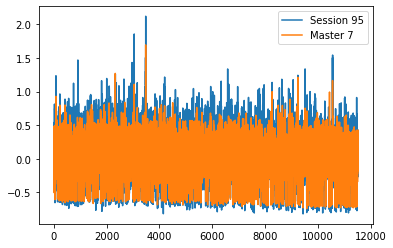

In [113]:
ri = 95
master_ind = matching_master_roi_index[ri]

plt.plot(dff_session[ri], label=f'Session {ri}')
plt.plot(dff_master[master_ind], label=f'Master {master_ind}')
plt.legend()

In [59]:
# Check if the signals are similar between single session lambda=1 and those from matching master ROIs
matching_master_roi_index = roi_collection['final_matching_master_roi_index_list'][si]
matching_master_roi_index

array([235, 132,   2,  81, 131,  18, 133,  37,  51, 102, 197, 164,   3,
        38,   1,  41, 195, 143,  19,  20,  21, 241,  83, 146,  79,  58,
       149,   6, 222,   5,  57, 196, 166, 221, 107, 192,  52,  22, 194,
         4,  62, 135, 165, 171,  23, 138, 201,  39,  47,  42,  88,  65,
        24, 111,  40,  25, 109,  26, 120,   0, 152,  70,  56,  27,  68,
       172,  28, 153, 114,  29,  30,   9,  31, 189, 259,  44,  14, 240,
       140, 275,  60,  91, 105, 112,  32,  50, 117,  33,  90,  43, 169,
       234,  34, 179, 215,   7,  35,  36], dtype=int64)

In [123]:
from suite2p import extraction
from suite2p.extraction import create_masks_and_extract
from suite2p.detection import roi_stats
from scipy.ndimage import filters

def calculate_dff(F: np.ndarray, baseline: str, win_baseline: float,
               sig_baseline: float, fs: float, prctile_baseline: float = 8) -> np.ndarray:
    """ Copied from extraction.preprocess
    """
    win = int(win_baseline*fs)
    if baseline == 'maximin':
        Flow = filters.gaussian_filter(F,    [0., sig_baseline])
        Flow = filters.minimum_filter1d(Flow,    win)
        Flow = filters.maximum_filter1d(Flow,    win)
    elif baseline == 'constant':
        Flow = filters.gaussian_filter(F,    [0., sig_baseline])
        Flow = np.amin(Flow)
    elif baseline == 'constant_prctile':
        Flow = np.percentile(F, prctile_baseline, axis=1)
        Flow = np.expand_dims(Flow, axis = 1)
    else:
        Flow = 0.

    F = F - Flow
    dff = F/Flow

    return F, dff

for mi in tqdm.notebook.tqdm(range(3)):
    mouse = mice[mi]
    for pn in tqdm.notebook.tqdm(range(1,9)):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
        session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
        edge_buffer = session_to_session_registration['edge_buffer']
        topBuffer = edge_buffer['topBuffer']
        leftBuffer = edge_buffer['leftBuffer']
        selected_session_num = session_to_session_registration['selected_session_num']

        num_session = len(selected_session_num)
        for si in range(num_session):
            sn = selected_session_num[si]
            master_map_session = roi_collection['final_master_map_sessions'][si]

            opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
            ops = np.load(opsFn, allow_pickle=True).item()
            ops['reg_file'] = f'{planeDir}{sn:03}/plane0/data.bin'

            stat_master = []
            for roi_map in master_map_session:
                s = {}
                ypix, xpix = np.where(roi_map>=0.5)
                s['ypix'] = ypix + topBuffer
                s['xpix'] = xpix + leftBuffer
                s['lam'] = np.ones(len(ypix))/len(ypix)
                stat_master.append(s)
            stat_master = np.array(stat_master)

            iscell_master = np.ones((len(stat_master),2))

            if 'aspect' in ops:
                dy, dx = int(ops['aspect'] * 10), 10
            else:
                d0 = ops['diameter']
                dy, dx = (d0, d0) if isinstance(d0, int) else d0
                
            stat_master = roi_stats(stat_master, dy = dy, dx = dx, Ly = ops['Ly'], Lx = ops['Lx']) # This creates other stats along with stat['radius']

            ops, stat_master, F, Fneu, _, _ = create_masks_and_extract(ops, stat_master)

            dF = F.copy() - ops['neucoeff']*Fneu
            dF, dff = calculate_dff(
                F=dF,
                baseline=ops['baseline'],
                win_baseline=ops['win_baseline'],
                sig_baseline=ops['sig_baseline'],
                fs=ops['fs'],
                prctile_baseline=ops['prctile_baseline']
            )
            spks = extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

            ops['save_path'] = f'{planeDir}{sn:03}/plane0/from_master_map/'
            fpath = ops['save_path']
            if os.path.isdir(fpath) != True:
                os.mkdir(fpath)
            np.save(os.path.join(fpath, 'ops.npy'), ops)
            np.save(os.path.join(fpath, 'stat.npy'), stat_master)
            np.save(os.path.join(fpath,'F.npy'), F)
            np.save(os.path.join(fpath,'Fneu.npy'), Fneu)
            np.save(os.path.join(fpath,'iscell.npy'), iscell_master)
            np.save(os.path.join(fpath, 'spks.npy'), spks)
            np.save(os.path.join(fpath, 'dff.npy'), dff)

            # Re-calculating signal with lambda==1
            ops = np.load(opsFn, allow_pickle=True).item()

            ops['reg_file'] = f'{planeDir}{sn:03}/plane0/data.bin'
            ops['save_path'] = f'{planeDir}{sn:03}/plane0/equal_lam/'

            statFn = f'{planeDir}{sn:03}/plane0/stat.npy'
            stat = np.load(statFn, allow_pickle=True)
            iscellFn = f'{planeDir}{sn:03}/plane0/iscell.npy'
            iscell = np.load(iscellFn, allow_pickle=True)
            viable_ind = roi_collection['final_viable_cell_index_list'][si]
            iscell = iscell[viable_ind,:]
            stat = stat[viable_ind]

            ops, stat, F, Fneu, _, _ = create_masks_and_extract(ops, stat)
            # remove 'imerge' from stat (set all ['imerge'] value to [0], if there is)
            if 'imerge' in stat[0].keys():
                for s in stat:
                    s['imerge'] = []

            dF = F.copy() - ops['neucoeff']*Fneu
            dF, dff = calculate_dff(
                F=dF,
                baseline=ops['baseline'],
                win_baseline=ops['win_baseline'],
                sig_baseline=ops['sig_baseline'],
                fs=ops['fs'],
                prctile_baseline=ops['prctile_baseline']
            )
            spks = extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

            fpath = ops['save_path']
            if os.path.isdir(fpath) != True:
                os.mkdir(fpath)
            np.save(os.path.join(fpath, 'ops.npy'), ops)
            np.save(os.path.join(fpath, 'stat.npy'), stat)
            np.save(os.path.join(fpath,'F.npy'), F)
            np.save(os.path.join(fpath,'Fneu.npy'), Fneu)
            np.save(os.path.join(fpath,'iscell.npy'), iscell)
            np.save(os.path.join(fpath, 'spks.npy'), spks)
            np.save(os.path.join(fpath, 'dff.npy'), dff)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Masks created, 1.40 sec.
Extracted fluorescence from 155 ROIs in 5006 frames, 14.90 sec.
Masks created, 1.17 sec.
Extracted fluorescence from 58 ROIs in 5006 frames, 9.20 sec.
Masks created, 1.77 sec.
Extracted fluorescence from 155 ROIs in 11526 frames, 22.11 sec.
Masks created, 1.03 sec.
Extracted fluorescence from 59 ROIs in 11526 frames, 18.51 sec.
Masks created, 1.61 sec.
Extracted fluorescence from 155 ROIs in 7781 frames, 12.74 sec.
Masks created, 1.08 sec.
Extracted fluorescence from 66 ROIs in 7781 frames, 12.86 sec.
Masks created, 1.44 sec.
Extracted fluorescence from 155 ROIs in 10463 frames, 47.70 sec.
Masks created, 1.14 sec.
Extracted fluorescence from 60 ROIs in 10463 frames, 17.03 sec.
Masks created, 1.68 sec.
Extracted fluorescence from 155 ROIs in 7970 frames, 14.53 sec.
Masks created, 0.88 sec.
Extracted fluorescence from 47 ROIs in 7970 frames, 12.93 sec.
Masks created, 1.26 sec.
Extracted fluorescence from 155 ROIs in 5293 frames, 9.39 sec.
Masks created, 0.96 sec.

  0%|          | 0/8 [00:00<?, ?it/s]

Masks created, 1.61 sec.
Extracted fluorescence from 210 ROIs in 13320 frames, 85.10 sec.
Masks created, 1.20 sec.
Extracted fluorescence from 118 ROIs in 13320 frames, 19.53 sec.
Masks created, 1.51 sec.
Extracted fluorescence from 210 ROIs in 11545 frames, 55.24 sec.
Masks created, 0.97 sec.
Extracted fluorescence from 65 ROIs in 11545 frames, 16.27 sec.
Masks created, 1.55 sec.
Extracted fluorescence from 210 ROIs in 9132 frames, 34.47 sec.
Masks created, 1.02 sec.
Extracted fluorescence from 72 ROIs in 9132 frames, 12.07 sec.
Masks created, 1.49 sec.
Extracted fluorescence from 210 ROIs in 12320 frames, 59.09 sec.
Masks created, 1.02 sec.
Extracted fluorescence from 60 ROIs in 12320 frames, 17.54 sec.
Masks created, 1.65 sec.
Extracted fluorescence from 210 ROIs in 10009 frames, 49.09 sec.
Masks created, 0.96 sec.
Extracted fluorescence from 64 ROIs in 10009 frames, 14.29 sec.
Masks created, 1.58 sec.
Extracted fluorescence from 210 ROIs in 7032 frames, 32.82 sec.
Masks created, 1.

  0%|          | 0/8 [00:00<?, ?it/s]

Masks created, 1.33 sec.
Extracted fluorescence from 172 ROIs in 9747 frames, 46.05 sec.
Masks created, 0.93 sec.
Extracted fluorescence from 48 ROIs in 9747 frames, 12.82 sec.
Masks created, 1.44 sec.
Extracted fluorescence from 172 ROIs in 9164 frames, 39.20 sec.
Masks created, 0.89 sec.
Extracted fluorescence from 46 ROIs in 9164 frames, 12.27 sec.
Masks created, 1.29 sec.
Extracted fluorescence from 172 ROIs in 9148 frames, 41.07 sec.
Masks created, 0.92 sec.
Extracted fluorescence from 55 ROIs in 9148 frames, 12.31 sec.
Masks created, 1.34 sec.
Extracted fluorescence from 172 ROIs in 8981 frames, 37.91 sec.
Masks created, 0.94 sec.
Extracted fluorescence from 52 ROIs in 8981 frames, 12.37 sec.
Masks created, 1.30 sec.
Extracted fluorescence from 172 ROIs in 10015 frames, 45.24 sec.
Masks created, 1.11 sec.
Extracted fluorescence from 54 ROIs in 10015 frames, 14.70 sec.
Masks created, 1.33 sec.
Extracted fluorescence from 172 ROIs in 5466 frames, 27.60 sec.
Masks created, 0.85 sec.

In [122]:
session_to_session_registration['selected_session_num']

array([ 1,  2,  3,  4,  5,  6, 13, 15, 17, 19, 22, 23, 24])

In [121]:

session_to_session_registration.keys()

dict_keys(['mouse', 'plane', 'edge_buffer', 'selected_session_i', 'selected_session_num', 'zdrift_list', 'registration_method', 'bilinear_result', 'affine_result', 'suite2p_result', 'old_result'])

# QC
- Compare F not dF/F0, because "equal_lambda" has fewer other ROIs segmented, leading to larger neuropil signals.


In [127]:
# From a plane in a mouse
mi = 0
mouse = mice[mi]
pn = 1
planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
print(len(selected_session_num))


13


In [132]:
# From one example session of this plane
si = 3
sn = selected_session_num[si]
matching_master_roi_index = roi_collection['final_matching_master_roi_index_list'][si]
dff_master = np.load(f'{planeDir}{sn:03}/plane0/from_master_map/dff.npy', allow_pickle=True)
dff_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/dff.npy', allow_pickle=True)
dff_session.shape

(60, 10463)

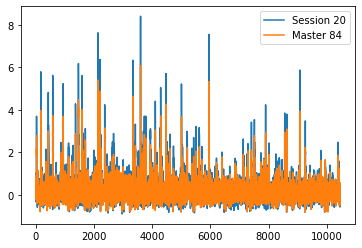

In [135]:
# Look at an individual ROI
ri = 20
master_ind = matching_master_roi_index[ri]

plt.plot(dff_session[ri], label=f'Session {ri}')
plt.plot(dff_master[master_ind], label=f'Master {master_ind}')
plt.legend()

(array([ 2.,  2.,  0.,  2.,  2.,  5.,  7., 11.,  9., 20.]),
 array([0.59235049, 0.63275937, 0.67316824, 0.71357712, 0.75398599,
        0.79439486, 0.83480374, 0.87521261, 0.91562149, 0.95603036,
        0.99643924]),
 <BarContainer object of 10 artists>)

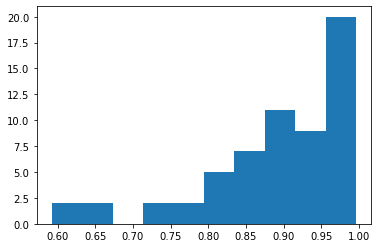

In [137]:
# Gather correlation coefficients of dffs between matched ROIs
dff_cc = np.zeros(len(matching_master_roi_index))
for ri in range(len(matching_master_roi_index)):
    master_ind = matching_master_roi_index[ri]
    roi_dff_session = dff_session[ri]
    matched_roi_dff_master = dff_master[master_ind]
    dff_cc[ri] = np.corrcoef(roi_dff_session, matched_roi_dff_master)[0,1]
plt.hist(dff_cc)


Text(0.5, 1.0, 'Correlation = 0.5923504933658548')

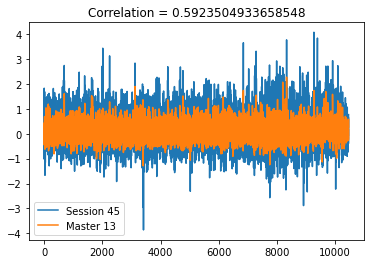

In [145]:
# Look at the lowest cc examples
sorted_ind = np.argsort(dff_cc)
dci = 0
ri = sorted_ind[dci]
master_ind = matching_master_roi_index[ri]
plt.plot(dff_session[ri], label=f'Session {ri}')
plt.plot(dff_master[master_ind], label=f'Master {master_ind}')
plt.legend()
plt.title(f'Correlation = {dff_cc[ri]}')


In [158]:
# Show the ROI map of an example
stat_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)

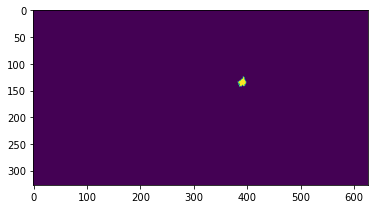

In [160]:
edge_buffer = session_to_session_registration['edge_buffer']
topBuffer = edge_buffer['topBuffer']
leftBuffer = edge_buffer['leftBuffer']

roi_map_session = np.zeros_like(roi_collection['final_master_map_sessions'][si][0,:,:])
roi_map_session[stat_session[ri]['ypix']-topBuffer, stat_session[ri]['xpix']-leftBuffer] = 1
plt.imshow(roi_map_session)


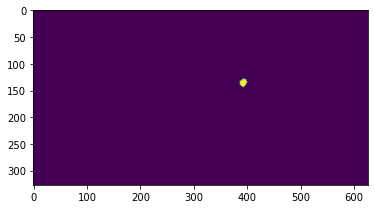

In [161]:
roi_map_master = roi_collection['final_master_map_sessions'][si][master_ind,:,:]
plt.imshow(roi_map_master)

In [391]:
# Collect correlation coefficient from all the sessions
# Save the results for each plane (gather all session values to the plane)
for mi in tqdm.notebook.tqdm(range(3)):
    mouse = mice[mi]
    for pn in tqdm.notebook.tqdm(range(1,9)):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
        session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
        selected_session_num = session_to_session_registration['selected_session_num']

        F_plane = []
        for si in range(len(selected_session_num)):
            sn = selected_session_num[si]
            matching_master_roi_index = roi_collection['final_matching_master_roi_index_list'][si]
            F_master = np.load(f'{planeDir}{sn:03}/plane0/from_master_map/F.npy', allow_pickle=True)
            F_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/F.npy', allow_pickle=True)
            stat_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)
            if 'imerge' in stat_session[0].keys():
                for s in stat_session:
                    s['imerge'] = []
            np.save(f'{planeDir}{sn:03}/plane0/equal_lam/stat.npy', stat_session)

            F_cc_session = np.zeros(len(matching_master_roi_index))
            for ri in range(len(matching_master_roi_index)):
                master_ind = matching_master_roi_index[ri]
                roi_F_session = F_session[ri]
                matched_roi_F_master = F_master[master_ind]
                F_cc_session[ri] = np.corrcoef(roi_F_session, matched_roi_F_master)[0,1]
            F_plane.append(F_cc_session)

        save_fn = f'{planeDir}roi_collection_qc_F_cc.npy'
        np.save(save_fn, F_plane)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

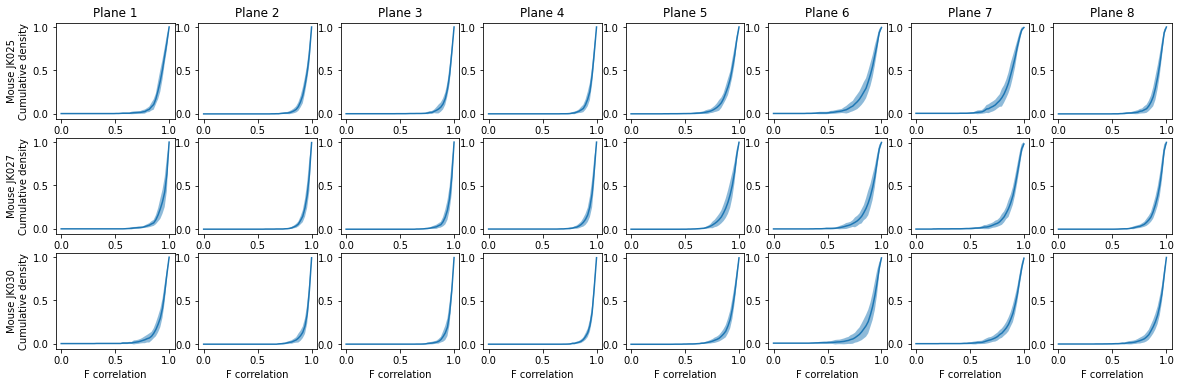

In [350]:
# Plot the distribution of correlation coefficients
fig, ax = plt.subplots(3,8,figsize=(20,6))
hist_bins = np.concatenate((np.array([-1]),(np.linspace(0,1,50))))
total_hist = []
total_cc = []
num_sessions = []
num_rois = []
for mi in range(3):
    mouse = mice[mi]
    for pn in range(1,9):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        qc_F_cc = np.load(f'{planeDir}roi_collection_qc_F_cc.npy',allow_pickle=True)
        num_sessions.append(len(qc_F_cc))        
        plane_hist = np.zeros((len(qc_F_cc),len(hist_bins)-1))
        for i, cc in enumerate(qc_F_cc):
            plane_hist[i,:] = np.cumsum(np.histogram(cc, bins=hist_bins)[0]/len(cc))
            num_rois.append(len(cc))
            total_cc.extend(cc)
        total_hist.extend(plane_hist)
        ax[mi,pn-1].plot(hist_bins[1:],np.mean(plane_hist,axis=0))
        ax[mi,pn-1].fill_between(hist_bins[1:], np.mean(plane_hist,axis=0)-np.std(plane_hist,axis=0), np.mean(plane_hist,axis=0)+np.std(plane_hist,axis=0), alpha=0.5)
        if mi == 0:
            ax[mi,pn-1].set_title(f'Plane {pn}')
        if pn == 1:
            ax[mi,pn-1].set_ylabel(f'Mouse JK{mouse:03}\nCumulative density')
        if mi == 2:
            ax[mi,pn-1].set_xlabel('F correlation')
total_cc = np.array(total_cc)

Text(0.5, 1.0, '95% of ROIs have DFF correlation > 0.755')

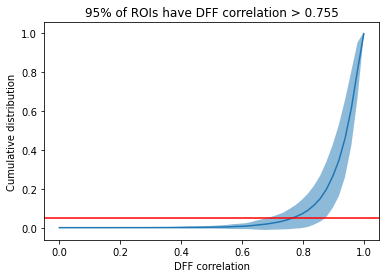

In [351]:
mean_hist = np.mean(np.array(total_hist),axis=0)
std_hist = np.std(np.array(total_hist),axis=0)
fig, ax = plt.subplots()
ax.plot(hist_bins[1:],mean_hist)
ax.fill_between(hist_bins[1:], mean_hist-std_hist, mean_hist+std_hist, alpha=0.5)
ax.axhline(0.05,color='r')
ax.set_xlabel('DFF correlation')
ax.set_ylabel('Cumulative distribution')
over_5 = hist_bins[np.where(mean_hist>0.05)[0][0]]
ax.set_title(f'95% of ROIs have DFF correlation > {over_5:.3}')

In [358]:
len(total_cc)

32719

In [357]:
np.sum(np.isnan(total_cc))

65

In [362]:
65/32719

0.0019866132828020417

In [363]:
np.sort(total_cc[np.where(np.isfinite(total_cc))[0]])

array([0.15203208, 0.15221858, 0.18731397, ..., 0.99966782, 0.9996903 ,
       0.99971264])

In [364]:
len(np.where(total_cc<0.5)[0])

60

In [365]:
60/32719

0.0018337968764326538

In [375]:
# Low correlation examples
sorted_ind = np.argsort(total_cc)
# Low values at the beginning, NaN values at the end

From total_cc: 0.3621726720782155
From session cc: 0.3621726720782155


Text(0.5, 1.0, 'JK025 plane5 S005\nCorrelation coefficient: 0.362')

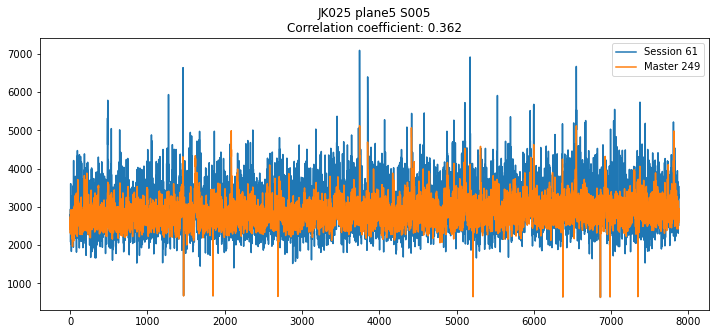

In [434]:
# Find mouse, plane, and session index from the index of total_cc
example_roi_ind = sorted_ind[14]

cum_num_rois = np.cumsum(num_rois)
session_ind_from_all = np.where(cum_num_rois > example_roi_ind)[0][0]

if session_ind_from_all == 0:
    roi_ind_from_session = example_roi_ind
else:
    roi_ind_from_session = example_roi_ind - cum_num_rois[session_ind_from_all-1]

cum_num_sessions = np.cumsum(num_sessions)
plane_ind_from_all = np.where(cum_num_sessions > session_ind_from_all)[0][0]
if plane_ind_from_all == 0:
    session_ind_from_plane = session_ind_from_all
else:
    session_ind_from_plane = session_ind_from_all - cum_num_sessions[plane_ind_from_all - 1]

mi = plane_ind_from_all // 8
mouse = mice[mi]
pn = (plane_ind_from_all % 8) + 1

planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
qc_F_cc = np.load(f'{planeDir}roi_collection_qc_F_cc.npy',allow_pickle=True)

print(f'From total_cc: {total_cc[example_roi_ind]}')
print(f'From session cc: {qc_F_cc[session_ind_from_plane][roi_ind_from_session]}')

roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
sn = selected_session_num[session_ind_from_plane]
matching_master_roi_index = roi_collection['final_matching_master_roi_index_list'][session_ind_from_plane]
F_master = np.load(f'{planeDir}{sn:03}/plane0/from_master_map/F.npy', allow_pickle=True)
F_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/F.npy', allow_pickle=True)
master_ind = matching_master_roi_index[roi_ind_from_session]

cc_val = np.corrcoef(F_session[roi_ind_from_session], F_master[master_ind])[0,1]
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(F_session[roi_ind_from_session], label=f'Session {roi_ind_from_session}',zorder=0)
ax.plot(F_master[master_ind], label=f'Master {master_ind}', zorder=1)
ax.legend()
ax.set_title(f'JK{mouse:03} plane{pn} S{sn:03}\nCorrelation coefficient: {cc_val:.3f}')
# plt.ylim([-1, 10])

In [112]:
# Testing normalizing lam before passing it or not.
stat = []
for roi_map in master_map:
    s = {}
    ypix, xpix = np.where(roi_map)
    s['ypix'] = ypix + topBuffer
    s['xpix'] = xpix + leftBuffer
    s['lam'] = np.ones(len(ypix))
    stats.append(s)
stats = np.array(stats)

stats = roi_stats(stats, dy = dy, dx = dx, Ly = ops['Ly'], Lx = ops['Lx']) # This creates other stats along with stat['radius']

ops, stats, F_wonorm, Fneu_wonorm, _, _ = create_masks_and_extract(ops, stats)
# Signals are exactly the same

Masks created, 1.36 sec.
Extracted fluorescence from 167 ROIs in 5006 frames, 8.85 sec.


# Highly correlated fluorescence signal between session ROIs and master ROIs
- Some discrepancy from bad ROI in the master map
- Manually curate master ROI again (at the first session in each plane).
- Apply this curation to all the other sessions.
- Be carefule about "iscell" for merged ROIs.

In [438]:
for mi in range(1,3):
    mouse = mice[mi]
    for pn in range(1,9):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
        selected_session_num = session_to_session_registration['selected_session_num']
        sn = selected_session_num[0]
        source_dn = f'{planeDir}{sn:03d}/plane0/from_master_map - Copy/'
        dest_dn = f'{planeDir}{sn:03d}/plane0/filtered_master_map/'
        os.rename(source_dn, dest_dn)


In [3]:
# Don't do this. It is risky. (see 220924_final_signal_extraction.ipynb)
# # Copy manually curated master maps to "filtered_master_map"
# for mi in range(3):
#     mouse = mice[mi]
#     for pn in range(1,9):
#         planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
#         session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
#         selected_session_num = session_to_session_registration['selected_session_num']
#         first_sn = selected_session_num[0]
#         first_dn = f'{planeDir}{first_sn:03d}/plane0/filtered_master_map/'
#         first_iscell = np.load(f'{first_dn}iscell.npy',allow_pickle=True)
#         for sn in selected_session_num[1:]:
#             # Copy from_master_map folder to final_master_map
#             source_dn = f'{planeDir}{sn:03d}/plane0/from_master_map/'
#             dest_dn = f'{planeDir}{sn:03d}/plane0/filtered_master_map/'
#             if os.path.isdir(dest_dn) != True:
#                 os.mkdir(dest_dn)
#             shutil.copytree(source_dn, dest_dn, dirs_exist_ok=True)